# House Price Prediction - Regression Analysis

In [3]:
%matplotlib inline

import csv

import scipy
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import FileLink, FileLinks, display, HTML
from sklearn.model_selection import GridSearchCV , KFold, cross_val_score, train_test_split
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [4]:
# Set these options to display all the columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
def write_csv(output_fn, ids, test_y):
    with open(output_fn, "w") as fp:
        writer = csv.writer(fp)
        writer.writerow(['Id', 'SalePrice'])
        for _id, y in zip(ids, test_y):
            writer.writerow([_id, y])

In [6]:
base_path = "./data"

In [7]:
def train_model(train_X, train_y, **kwargs):
    model = XGBRegressor(**kwargs)
    model.fit(train_X, train_y, verbose=True)
    return model

=Baseline model

In [6]:
testdf = pd.read_csv(f"{base_path}/test.csv")
traindf = pd.read_csv(f"{base_path}/train.csv")

Check for null values and delete them before we proceed. We don't have any in our case

In [57]:
traindf['SalePrice'].isnull().values.any()

False

Understand some basics about the data. For convenience i split them into two parts 

In [59]:
traindf.select_dtypes(exclude=['object']).describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [60]:
train_data.select_dtypes(include=['object']).describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


Convert the string data into categorical. 

In [65]:
traindf[traindf.select_dtypes(['object']).columns] = traindf.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [78]:
y = traindf.SalePrice
X = traindf.drop(['SalePrice'], axis=1).select_dtypes(exclude=['category'])

In [115]:
model = train_model(X, y)

On our first try lets remove all the categorical data and try. 

In [84]:
test_X = testdf.select_dtypes(exclude=['object'])
test_y = model.predict(test_X)

In [108]:
write_csv("house_price_predict_1.csv", test_X['Id'], test_y)
FileLink("house_price_predict_1.csv")

/media/disk6tb/myfiles/fastai_v1/notebooks/house_price_predict_1.csv

After submission, we got about 0.14179 score with our test data. We are approximately at 50 percentile ! position. You might get a different score because of randomization. 

In [15]:
def show_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1)
    display(missing_data.head(30))

#show_missing_data(traindf)
#show_missing_data(testdf)

## More serious model :)
You can see that data is missing in some columns. These columns are different for test vs train. We need to come up with some strategy to replace the null fields. For convenience we will merge the train and test sets together and apply the same transformations for both the datasets.

In [145]:
testdf = pd.read_csv(f"{base_path}/test.csv")
traindf = pd.read_csv(f"{base_path}/train.csv")

# Remove outliers. 
traindf = traindf.drop(traindf[traindf['Id'] == 1299].index)
traindf = traindf.drop(traindf[traindf['Id'] == 524].index)

# The assumption here is, it is easier to model linear data. If you plot our sales price, the distribution is skewed
# We do log transformation for making it linear
traindf["SalePrice"] = np.log1p(traindf["SalePrice"])

y = traindf.SalePrice
df = pd.concat([traindf.drop(['SalePrice'], axis=1), testdf], axis=0)

print(f"DataFrame Shape: {df.shape}")

DataFrame Shape: (2917, 80)


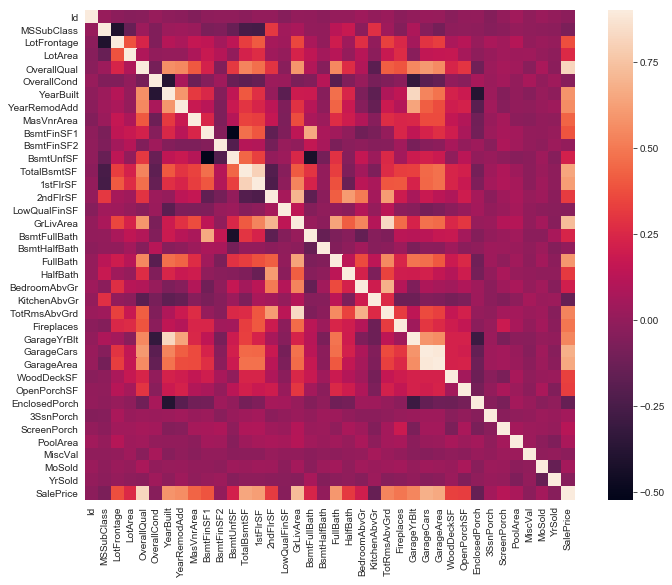

In [9]:
# Correlation matrix. Higher the numberm, the more they are correlated. You can also find some colinear columns. 
# For example check, GarageCars and GarageArea. Also TotalBsmtSF and 1stFlrSF
corrmat = traindf.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [18]:
rating = {
    "Ex": 5,
    "Gd": 4,
    "TA": 3,
    "Fa": 2,
    "Po": 1,
    "None": 0,
}

basement_type = {
    "GLQ": 6,
    "ALQ": 5,
    "BLQ": 4,
    "Rec": 3,
    "LwQ": 2,
    "Unf": 1,
    "None": 0,
}

fence_type = {
    "GdPrv": 4,
    "MnPrv": 1,
    "GdWo": 3,
    "MnWw": 2,
    "NA": 0,
    "None": 0,   
}

# This is the single most important transformation in the whole excercise. We need to provide sensible values to the 
# ordinal transformation. For example regular shaped plots are more prefered than irregular shaped plots. Go 
# through the data description multiple times and provide sensible values.
MAPPING = {
    "PoolQC":  rating,
    "FireplaceQu": rating,
    "GarageCond": rating,
    "GarageQual": rating,
    "BsmtQual": rating,
    "BsmtCond": rating,
    "BsmtExposure": {
        "Gd": 4,
        "Av": 3,
        "Mn": 2,
        "No": 1,
        "None": 0,
    },
    "KitchenQual": rating,
    "ExterQual": rating,
    "ExterCond": rating,
    "LotShape": {
        "Reg": 3,
        "IR1": 2,
        "IR2": 1,
        "IR3": 0,
    },
    "BsmtFinType1": basement_type,
    "BsmtFinType2": basement_type,
    "MasVnrType": {
        "Stone": 2,
        "BrkFace": 1,
        "BrkCmn": 0,
        "None": 0,
    },
    "Functional": {
        np.NaN: 7,
        "None": 7,
        "Sal": 0,
        "Sev": 1,
        "Maj2": 2,
        "Maj1": 3,
        "Mod": 4,
        "Min2": 5,
        "Min1": 6,
        "Typ": 7,    
    },
    "HeatingQC": rating,
    "Fence": fence_type,
    "GarageFinish": {
        "Fin": 3,
        "RFn": 2,
        "Unf": 1,
        "NA": 0,
        "None": 0
    },
    "LandSlope": {
        "Gtl": 3,
        "Mod": 2,
        "Sev": 1,
    },
    "PavedDrive": {
        "Y": 3,
        "P": 2,
        "N": 1
    },
    "Street": {
        "Grvl": 1,
        "Pave": 2
    },
    "Alley": {
        "Grvl": 1,
        "Pave": 2,
    },
    "CentralAir": {
        "Y": 2,
        "N": 1,
    },
    "MSSubClass": {
        20: 1,
        30: 2,
        40: 3,
        45: 4,
        50: 5,
        60: 6,
        70: 7,
        75: 8,
        80: 9,
        85: 10,
        90: 11,
        120: 12,
        150: 13,
        160: 14,
        180: 15,
        190: 16,
    },
    "YrSold": {
        2006: 1,
        2007: 2,
        2008: 3,
        2009: 4,
        2010: 5
    }
}

def encode_data(df, columns, mapping):
    for column in columns:
        df[column] = df[column].map(mapping[column])

cols_ordinal = list(MAPPING.keys())
cols_to_drop = ['Utilities']
cols_numeric = ['OverallCond', 'MoSold', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', "1stFlrSF", "2ndFlrSF", "Id", "YearBuilt", "YearRemodAdd",  "PoolArea", "LotArea", "GarageArea", "GarageYrBlt", "OverallQual", "WoodDeckSF", "TotRmsAbvGrd", "3SsnPorch", "BedroomAbvGr", "EnclosedPorch", "Fireplaces", "FullBath", "GarageCars", "HalfBath", "KitchenAbvGr", "LotFrontage", "LowQualFinSF", "MiscVal",  "OpenPorchSF", "ScreenPorch", "TotalBsmtSF", "GrLivArea"]
cols_categorical1 =  ['MiscFeature', 'LotConfig', 'GarageType', 'MSZoning', 'Exterior1st', 'Exterior2nd', 'Electrical', 'SaleType', 'SaleCondition']
cols_categorical2 = ["BldgType", "Condition1", "Condition2", "Foundation", "Heating", "HouseStyle", "LandContour",  "Neighborhood", "RoofMatl", "RoofStyle", "SaleCondition"]
cols_category = cols_categorical1 + cols_categorical2
skewed_cols = ['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', '1stFlrSF', 'GrLivArea', 'LotFrontage', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF']
lam = 0.15

def transform(df):
    neighborhood_lot = dict(df.groupby('Neighborhood')['LotFrontage'].mean())
    
    # Replace the empty LotFrontage's with neighborhood average
    df['LotFrontage'] = df.apply(lambda row: row['LotFrontage'] if pd.notnull(row['LotFrontage']) else neighborhood_lot[row['Neighborhood']], axis=1)
    
    # Replace null years for GarageYrBlt with the year built
    df['GarageYrBlt'] = df.apply(lambda row: row['GarageYrBlt'] if pd.notnull(row['GarageYrBlt']) else row['YearBuilt'], axis=1)
    
    # Remove unnecessary columns. They have values only for couple of examples
    df = df.drop(cols_to_drop, axis=1)

    # Ordinal encoding. 
    encode_data(df, cols_ordinal, MAPPING)

    # Missing values: According to data description, the missing value means the most common one ! 
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    # Replace null values
    df[cols_category] = df[cols_category].fillna('NA')
    df[cols_numeric] = df[cols_numeric].fillna(0)
    df[cols_ordinal] = df[cols_ordinal].fillna(0)

    # Convert some to categorical. This helps because of limited data. 
    #df[cols_convert_category] = df[cols_convert_category].astype(str)
    
    # Convert others to corresponding type
    df[cols_ordinal] = df[cols_ordinal].apply(lambda x: pd.to_numeric(x))
    df[cols_category] = df[cols_category].apply(lambda x: x.astype('category'))

    for feat in skewed_cols:
        df[feat] = boxcox1p(df[feat], lam)
        
    # Add a new feature
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    return df

print(f"DataFrame Shape Before modifying: {df.shape}")
df_trans = transform(df)
print(f"DataFrame Shape After modifying: {df_trans.shape}")

df_trans = pd.get_dummies(df_trans)
print(f"DataFrame Shape after get_dummies: {df_trans.shape}")

DataFrame Shape Before modifying: (2917, 80)
DataFrame Shape After modifying: (2917, 80)
DataFrame Shape after get_dummies: (2917, 218)


In [21]:
# Create train and test
no_train = len(y)
#df_trans = df_trans.drop(['Id'], axis=1)
X_train = df_trans[:no_train]
X_test = df_trans[no_train:]
print(f"X_train: {X_train.shape}, y: {no_train}, X_test: {X_test.shape}")

X_train: (1458, 218), y: 1458, X_test: (1459, 218)


In [23]:
# Generate model and dump the test data
model = train_model(X_train, y, colsample_bytree=0.4603, 
                    n_estimators=2200, max_depth=3, learning_rate=0.05, min_child_weight=1.7817,
                   reg_alpha=0.4640, reg_lambda=0.8571,subsample=0.5213, nthread = -1)

y_pred = model.predict(X_test)
y_pred = np.expm1(y_pred)

test_data_id = df[no_train:]['Id']
write_csv("house_price_after_tune.csv", test_data_id, y_pred)
FileLink("house_price_after_tune.csv")

/Users/pulikunt/myfiles/notebooks/house_price_after_tune.csv

In [53]:
def train_publish_model(model, X_train, y, X_test):
    model.fit(X_train, y)
    
    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred)
        
    test_data_id = df[no_train:]['Id']
    write_csv("house_price_after_tune.csv", test_data_id, y_pred)
    FileLink("house_price_after_tune.csv") 

In [19]:
# Make sure there are no missing values. 
show_missing_data(df_trans)

,0,1
SaleCondition_Partial,0,0.0
LandContour_Low,0,0.0
Neighborhood_ClearCr,0,0.0
Neighborhood_BrkSide,0,0.0
Neighborhood_BrDale,0,0.0
Neighborhood_Blueste,0,0.0
Neighborhood_Blmngtn,0,0.0
LotConfig_Inside,0,0.0
LotConfig_FR3,0,0.0
LotConfig_FR2,0,0.0


In [45]:
#We use cross validation to find out the predicted score for different techniques. 
n_folds = 5

def rmsle_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [25]:
# XGB Model
xgb_model = XGBRegressor(colsample_bytree=0.4603, 
                    n_estimators=2200, max_depth=3, learning_rate=0.05, min_child_weight=1.7817,
                   reg_alpha=0.4640, reg_lambda=0.8571,subsample=0.5213, nthread = -1)
cv_scores = rmsle_cv(xgb_model, X_train, y)
print("Xgboost score: {:.4f} ({:.4f})\n".format(cv_scores.mean(), cv_scores.std()))

Xgboost score: 0.1158 (0.0063)



In [22]:
# LASSO
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso, X_train, y)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1104 (0.0055)



In [95]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3, max_iter=3000))
score = rmsle_cv(ENet, X_train, y)
print("\nENet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ENet score: 0.1104 (0.0055)



In [58]:
KRR = KernelRidge(alpha=0.1, kernel='polynomial', degree=1, coef0=2.5)
score = rmsle_cv(KRR, X_train, y)
print("\nKernelRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KernelRidge score: 0.1130 (0.0047)



In [60]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost, X_train, y)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GBoost score: 0.1166 (0.0069)



In [61]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb, X_train, y)
print("\nLGB score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGB score: 0.1165 (0.0060)



In [40]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [42]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models, X_train, y)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1084 (0.0052)



In [54]:
train_publish_model(averaged_models, X_train, y, X_test)
FileLink("house_price_after_tune.csv") 
# Got around .11840 in public leaderboard

In [64]:
averaged_models1 = AveragingModels(models = (lasso, xgb_model, model_lgb))
score = rmsle_cv(averaged_models, X_train, y)
print(" Averaged1 base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged1 base models score: 0.1084 (0.0052)



In [69]:
averaged_models.fit(X_train, y)
average_train_pred = averaged_models.predict(X_train)
average_pred = np.expm1(averaged_models.predict(X_test))
print(rmsle(y, average_train_pred))

0.08355134474984019


In [65]:
train_publish_model(averaged_models1, X_train, y, X_test)
FileLink("house_price_after_tune.csv") 

/Users/pulikunt/myfiles/notebooks/house_price_after_tune.csv

In [93]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [96]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)
score = rmsle_cv(stacked_averaged_models, X_train.values, y.values)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1074 (0.0056)


In [98]:
train_publish_model(stacked_averaged_models, X_train.values, y.values, X_test.values)
FileLink("house_price_after_tune.csv") 

/Users/pulikunt/myfiles/notebooks/house_price_after_tune.csv

In [100]:
stacked_averaged_models.fit(X_train.values, y.values)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
print(rmsle(y, stacked_train_pred))

0.08185286388069687


In [102]:
xgb_model.fit(X_train, y)
xgb_train_pred = xgb_model.predict(X_train)
xgb_pred = np.expm1(xgb_model.predict(X_test))
print(rmsle(y, xgb_train_pred))

0.041794705773656106


In [103]:
model_lgb.fit(X_train, y)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))
print(rmsle(y, lgb_train_pred))

0.07250378640167945


In [105]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07240731250426967


In [113]:
# This did not improve. Some how xgb overfitted here. 
print('RMSLE score on train data:')
print(rmsle(y,stacked_train_pred*0.50 +
               xgb_train_pred*0.35 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.06365876508149622


In [137]:
print('RMSLE score on train data:')
print(rmsle(y,stacked_train_pred*0.40 + lgb_train_pred*0.60 ))

RMSLE score on train data:
0.07387623566809344


In [106]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [138]:
ensemble = stacked_pred*0.40 + lgb_pred*0.60
#

In [139]:
sub = pd.DataFrame()
sub['Id'] = df[no_train:]['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv', index=False)
FileLink("submission.csv") 

/Users/pulikunt/myfiles/notebooks/submission.csv

In [11]:
## MODEL TUNING

param_test1 = {
 'max_depth':range(3, 5, 1),
 'min_child_weight':range(2, 6, 1),
 'n_estimators': range(500, 1000, 25)   
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.05, n_estimators=140, max_depth=5,
 min_child_weight=1, scale_pos_weight=1, seed=100, base_score=y.mean()), 
 param_grid = param_test1, n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y)
gsearch1.best_score_, gsearch1.best_params_, gsearch1.best_score_
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

(0.9230487755090074,
 {'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 975},
 0.9230487755090074)

In [ ]:
def model_report():
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

After above split i got 0.13139 

After removing the outliers it is improved to 0.12993

After setting every numberic to 0 and every non numeric to 'NA' 0.12987

After log transform it increased to 0.13376. 

In [69]:
# Label encoding
??OrdinalEncoder

1. http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/
1. https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
1. https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe
1. https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
1. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python 
1. https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
1. https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard